In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('pretrained_model/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('pretrained_model/trfm_pretrained.pkl', map_location=torch.device('cpu')))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('pretrained_model/rnn_pretrained.pkl', map_location=torch.device('cpu')))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BACE dataset

In [5]:
df = pd.read_csv('dataset/bace.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(1513, 595)


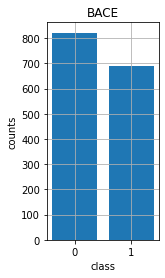

In [6]:
keys = ['0', '1']
bottom = df.groupby('Class').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BACE')
plt.grid()
plt.show()

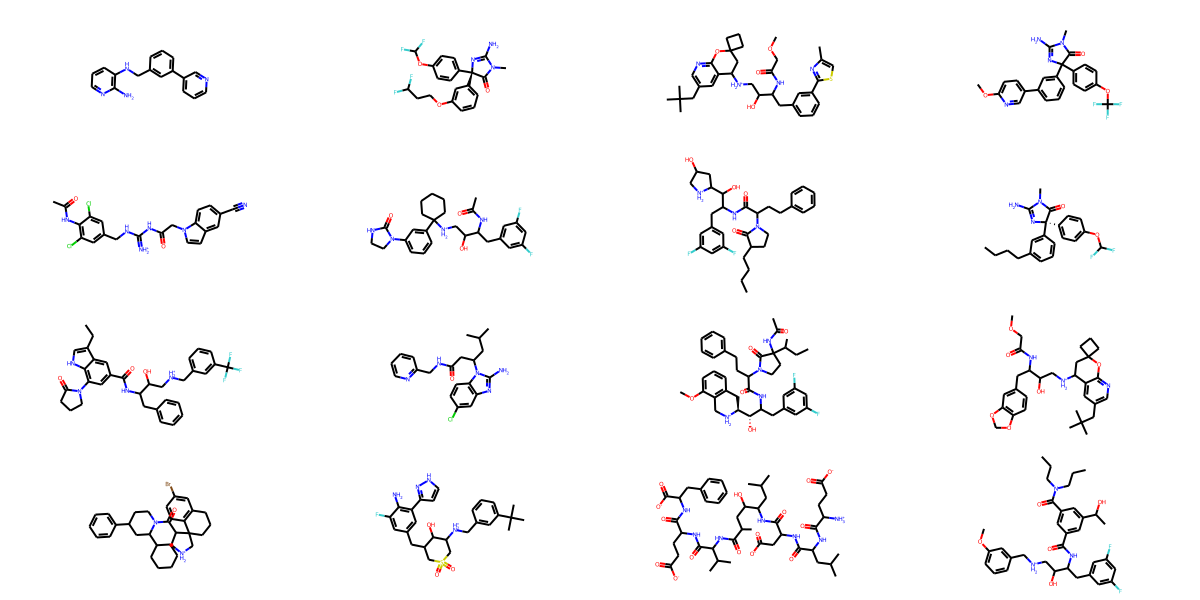

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.6150457269796392, 'roc_auc std': 0.04744761247895421, 'prc_auc mean': 0.5504642245454543, 'prc_auc std': 0.040316279012163274}
0.025 {'roc_auc mean': 0.6245257590445252, 'roc_auc std': 0.027854471796283947, 'prc_auc mean': 0.5649605114062726, 'prc_auc std': 0.019342625742644885}
0.05 {'roc_auc mean': 0.6127967890364185, 'roc_auc std': 0.02993185250297268, 'prc_auc mean': 0.5591062423229863, 'prc_auc std': 0.029102980180876255}
0.1 {'roc_auc mean': 0.6317633831580777, 'roc_auc std': 0.029488457164831942, 'prc_auc mean': 0.5761462842530785, 'prc_auc std': 0.032285868499365496}
0.2 {'roc_auc mean': 0.6568096374019577, 'roc_auc std': 0.02091696376754686, 'prc_auc mean': 0.60572189171021, 'prc_auc std': 0.019661558869680355}
0.4 {'roc_auc mean': 0.7020914489601406, 'roc_auc std': 0.01620501026962354, 'prc_auc mean': 0.6435933922929592, 'prc_auc std': 0.019179313548768107}
0.8 {'roc_auc mean': 0.7406916996047431, 'roc_auc std': 0.023062723650413754, 'prc_auc mean': 

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6059401798786864, 'roc_auc std': 0.03851507782971983, 'prc_auc mean': 0.5542542463478715, 'prc_auc std': 0.03947851992247529}
0.025 {'roc_auc mean': 0.6203539741151571, 'roc_auc std': 0.030026197989636134, 'prc_auc mean': 0.567601915900125, 'prc_auc std': 0.024940371253016434}
0.05 {'roc_auc mean': 0.6653788512171688, 'roc_auc std': 0.02447288225775113, 'prc_auc mean': 0.6197346602322066, 'prc_auc std': 0.024446653627389143}
0.1 {'roc_auc mean': 0.6970039432519335, 'roc_auc std': 0.018291088736627756, 'prc_auc mean': 0.6522138455682855, 'prc_auc std': 0.019433788376294937}
0.2 {'roc_auc mean': 0.7428518525643493, 'roc_auc std': 0.014841469787432818, 'prc_auc mean': 0.6976899573254248, 'prc_auc std': 0.014973253139283063}
0.4 {'roc_auc mean': 0.7737061022996652, 'roc_auc std': 0.01665841458631169, 'prc_auc mean': 0.7327435165290204, 'prc_auc std': 0.02014552298551297}
0.8 {'roc_auc mean': 0.810159200702679, 'roc_auc std': 0.01810998594547371, 'prc_auc mean': 0.

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5933341567555482, 'roc_auc std': 0.05087962421321328, 'prc_auc mean': 0.5511172701633646, 'prc_auc std': 0.037077323884898775}
0.025 {'roc_auc mean': 0.6203943498079726, 'roc_auc std': 0.026299039918342967, 'prc_auc mean': 0.5669527199253819, 'prc_auc std': 0.023380752481683257}
0.05 {'roc_auc mean': 0.6438046293535393, 'roc_auc std': 0.025491726978865405, 'prc_auc mean': 0.5819057786212298, 'prc_auc std': 0.022119492425453476}
0.1 {'roc_auc mean': 0.6684914617189537, 'roc_auc std': 0.02301136968438201, 'prc_auc mean': 0.6095366276220132, 'prc_auc std': 0.0201473896698462}
0.2 {'roc_auc mean': 0.7078612376811754, 'roc_auc std': 0.01652408884272718, 'prc_auc mean': 0.648957712399023, 'prc_auc std': 0.017973876848791853}
0.4 {'roc_auc mean': 0.7286702998607004, 'roc_auc std': 0.02047919829890756, 'prc_auc mean': 0.6677337888882692, 'prc_auc std': 0.02600966143918524}
0.8 {'roc_auc mean': 0.7727272727272727, 'roc_auc std': 0.026947439073633866, 'prc_auc mean': 0.

Classification evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


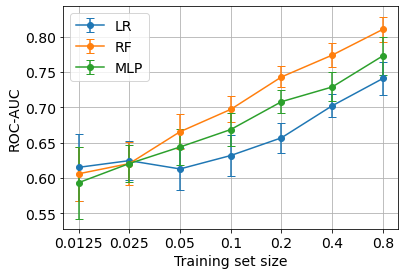

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.6019809014129203, 'roc_auc std': 0.05440976587723152, 'prc_auc mean': 0.5541192271648184, 'prc_auc std': 0.056937958180997374}
0.025 {'roc_auc mean': 0.6367088584177538, 'roc_auc std': 0.051812045990823036, 'prc_auc mean': 0.5744617541773187, 'prc_auc std': 0.05510811029729154}
0.05 {'roc_auc mean': 0.6800806638641869, 'roc_auc std': 0.026660178243868852, 'prc_auc mean': 0.6205297171305879, 'prc_auc std': 0.025620914402770825}
0.1 {'roc_auc mean': 0.726782176066742, 'roc_auc std': 0.02086083101879699, 'prc_auc mean': 0.6652963836311486, 'prc_auc std': 0.026501244333687717}
0.2 {'roc_auc mean': 0.7749635862963553, 'roc_auc std': 0.013111299806285887, 'prc_auc mean': 0.7206314411556747, 'prc_auc std': 0.01351725777500156}
0.4 {'roc_auc mean': 0.8042256653388401, 'roc_auc std': 0.010813533515450653, 'prc_auc mean': 0.7482594505999756, 'prc_auc std': 0.01670200444154519}
0.8 {'roc_auc mean': 0.8372353974527889, 'roc_auc std': 0.016974451042396182, 'prc_auc mean': 

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.565410271621144, 'roc_auc std': 0.03731262699849766, 'prc_auc mean': 0.5132348045480932, 'prc_auc std': 0.03484880354623048}
0.025 {'roc_auc mean': 0.5838905610602574, 'roc_auc std': 0.04178501164272241, 'prc_auc mean': 0.5342886148734592, 'prc_auc std': 0.03866897715993892}
0.05 {'roc_auc mean': 0.6271299723065109, 'roc_auc std': 0.028343543001048882, 'prc_auc mean': 0.5806232475802326, 'prc_auc std': 0.02915293834465464}
0.1 {'roc_auc mean': 0.6703036738506996, 'roc_auc std': 0.016579369040511754, 'prc_auc mean': 0.6258139878131789, 'prc_auc std': 0.021773993632183974}
0.2 {'roc_auc mean': 0.7132409845166185, 'roc_auc std': 0.017358573024171056, 'prc_auc mean': 0.6686869694535266, 'prc_auc std': 0.015000015541021016}
0.4 {'roc_auc mean': 0.7643576333732496, 'roc_auc std': 0.018939553426886788, 'prc_auc mean': 0.728424203172781, 'prc_auc std': 0.02421150514884967}
0.8 {'roc_auc mean': 0.8045026350461132, 'roc_auc std': 0.022254002181771645, 'prc_auc mean': 0.

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5833702370734735, 'roc_auc std': 0.045251124459722576, 'prc_auc mean': 0.5331633646181553, 'prc_auc std': 0.048931343907823596}
0.025 {'roc_auc mean': 0.6206329502652863, 'roc_auc std': 0.056389281579566325, 'prc_auc mean': 0.5677376800061157, 'prc_auc std': 0.05894563388957374}
0.05 {'roc_auc mean': 0.690381336030574, 'roc_auc std': 0.026603951297486324, 'prc_auc mean': 0.6379530734191684, 'prc_auc std': 0.027241856084343933}
0.1 {'roc_auc mean': 0.728070956808899, 'roc_auc std': 0.026420790556188355, 'prc_auc mean': 0.6744301492995538, 'prc_auc std': 0.024642016631476422}
0.2 {'roc_auc mean': 0.7773387216454047, 'roc_auc std': 0.012185452954928596, 'prc_auc mean': 0.7227171909766612, 'prc_auc std': 0.01936490472397444}
0.4 {'roc_auc mean': 0.7879579168601383, 'roc_auc std': 0.019194002194470167, 'prc_auc mean': 0.7363291859282917, 'prc_auc std': 0.021900556433805396}
0.8 {'roc_auc mean': 0.8595981554677208, 'roc_auc std': 0.01978517976303175, 'prc_auc mean':

SMILES TRANSFORMER evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


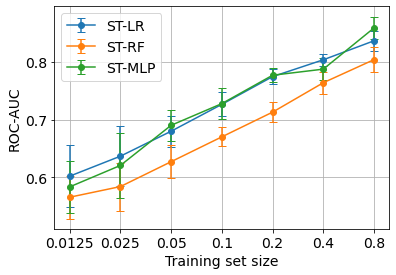

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BACE_st_eval.png', dpi=300)
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 1513 molecules. It will take a little time.
(1513, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5770796219229855, 'roc_auc std': 0.0383378752767488, 'prc_auc mean': 0.5224395164795674, 'prc_auc std': 0.04252065156145195}
0.025 {'roc_auc mean': 0.562833457898281, 'roc_auc std': 0.033341825641136004, 'prc_auc mean': 0.5073101876690094, 'prc_auc std': 0.034072644672058366}
0.05 {'roc_auc mean': 0.6306356055246659, 'roc_auc std': 0.025946202654640215, 'prc_auc mean': 0.561408700908721, 'prc_auc std': 0.027394509713002068}
0.1 {'roc_auc mean': 0.6716621404362562, 'roc_auc std': 0.022604021179474187, 'prc_auc mean': 0.5982587673721576, 'prc_auc std': 0.03255908002553788}
0.2 {'roc_auc mean': 0.7152635252862254, 'roc_auc std': 0.013855265264672996, 'prc_auc mean': 0.6513511931894311, 'prc_auc std': 0.019003376218595335}
0.4 {'roc_auc mean': 0.7537146557833769, 'roc_auc std': 0.014261142764837103, 'prc_auc mean': 0.6993719248442966, 'prc_auc std': 0.019559654338342572}
0.8 {'roc_auc mean': 0.7824813350900308, 'roc_auc std': 0.023775237663096582, 'prc_auc mean': 

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5900420305952441, 'roc_auc std': 0.036517167123175306, 'prc_auc mean': 0.5382845897956955, 'prc_auc std': 0.036687890427325474}
0.025 {'roc_auc mean': 0.6402548894825251, 'roc_auc std': 0.02863616931993083, 'prc_auc mean': 0.5947815488204722, 'prc_auc std': 0.03968712001543626}
0.05 {'roc_auc mean': 0.68102104393345, 'roc_auc std': 0.02980690043938018, 'prc_auc mean': 0.6433391388228197, 'prc_auc std': 0.036339062978550954}
0.1 {'roc_auc mean': 0.7288052381159295, 'roc_auc std': 0.019495461543979953, 'prc_auc mean': 0.6956926781345699, 'prc_auc std': 0.02337651676410735}
0.2 {'roc_auc mean': 0.7768127840955935, 'roc_auc std': 0.017760695228813312, 'prc_auc mean': 0.7429471630068054, 'prc_auc std': 0.020692951574458596}
0.4 {'roc_auc mean': 0.8141992717319584, 'roc_auc std': 0.010372835364549748, 'prc_auc mean': 0.782872570826489, 'prc_auc std': 0.012408709452987676}
0.8 {'roc_auc mean': 0.843580368906456, 'roc_auc std': 0.023661740724103358, 'prc_auc mean': 0.

RNN + Multi-layer Perceptron Classifier (MLP)

In [20]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['Class'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5605899159027472, 'roc_auc std': 0.051075750783772154, 'prc_auc mean': 0.5136645815754775, 'prc_auc std': 0.04876191185740629}
0.025 {'roc_auc mean': 0.5876504954231632, 'roc_auc std': 0.030279768169593567, 'prc_auc mean': 0.5319916484851499, 'prc_auc std': 0.03172544893763152}
0.05 {'roc_auc mean': 0.6334315078237517, 'roc_auc std': 0.026107894192786484, 'prc_auc mean': 0.5594434388751096, 'prc_auc std': 0.028635759843315536}
0.1 {'roc_auc mean': 0.6799010384983055, 'roc_auc std': 0.02006853818964112, 'prc_auc mean': 0.6074550515312948, 'prc_auc std': 0.0286895948851477}
0.2 {'roc_auc mean': 0.7009901779187301, 'roc_auc std': 0.021773293046829723, 'prc_auc mean': 0.6362992370964651, 'prc_auc std': 0.02711871635628051}
0.4 {'roc_auc mean': 0.6790416432464136, 'roc_auc std': 0.01887354872919853, 'prc_auc mean': 0.6123840221727284, 'prc_auc std': 0.02101496757441965}
0.8 {'roc_auc mean': 0.7238713219148003, 'roc_auc std': 0.027529585593029017, 'prc_auc mean': 0.

# Pre-training RNN Evaluation

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


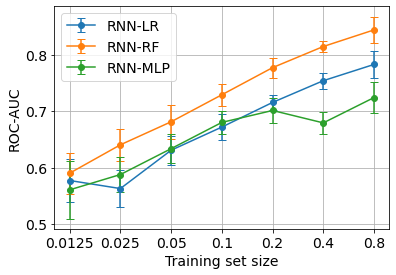

In [21]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


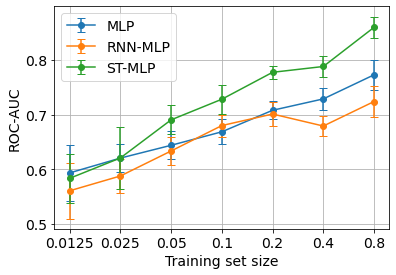

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BACE_pretrain_eval.png', dpi=300)
fig.show()

# Visualization of the Latent Space

In [23]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\theanh\appdata\local\programs\python\python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

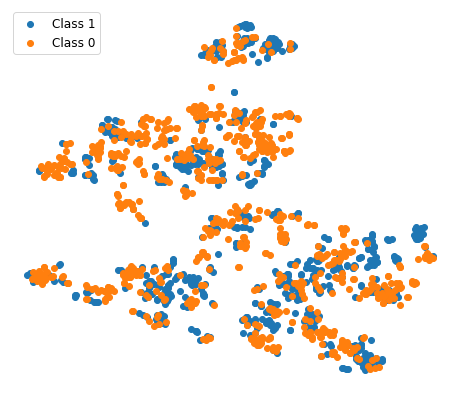

In [26]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['Class']==1][:,0], X_reduced[df['Class']==1][:,1], label='Class 1', marker='o')
plt.scatter(X_reduced[df['Class']==0][:,0], X_reduced[df['Class']==0][:,1], label='Class 0', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('figures/BACE.png', dpi=300)
plt.show()